In [1]:
# dependencies
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from citipy import citipy
import numpy as np
#import time
import os
import chardet

# establish openweather API key/url
file_name = "../../../PythonScripts/BootcampExercises/API_Keys/api_keys.json"
data = json.load(open(file_name))
key = data['openweather']
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"
query_url = url + "appid=" + key + "&units=" + units + "&q="

# get olympic data files
csv_path = os.path.join("../Resources", "GDP_allyears.csv")
gdp = pd.read_csv(csv_path)
csv_path = os.path.join("../Resources", "country_participation.csv")
participation = pd.read_csv(csv_path)
csv_path = os.path.join("../Resources", "country_codes.csv")
codes = pd.read_csv(csv_path)
csv_path = os.path.join("../Resources", "country_coordinates.csv")
with open(csv_path, 'rb') as f:
    result = chardet.detect(f.read())
coordinates = pd.read_csv(csv_path, encoding=result['encoding'])

In [2]:
# join in country codes
participation = participation.merge(codes, on='Country', how='left')

# clean/format participation data set
participation["TotalMedals"] = participation["Gold"] + participation["Silver"] + participation["Bronze"]
participation = participation.fillna(0)
participation["From"] = participation["From"].astype(int)
participation["To"] = participation["To"].astype(int)
participation["Gold"] = participation["Gold"].astype(int)
participation["Silver"] = participation["Silver"].astype(int)
participation["Bronze"] = participation["Bronze"].astype(int)
participation["Sports"] = participation["Sports"].astype(int)
participation["TotalAthletes"] = participation["Participants"].astype(int)
participation = participation.drop('Participants', 1)
participation["TotalMedals"] = participation["TotalMedals"].astype(int)
participation = participation.rename(columns={'Code':'CountryCode','Sports': 'TotalSports','Gold':'TotalGold','Silver':'TotalSilver','Bronze':'TotalBronze'})

In [3]:
# determine number of participation years
gameyears = [1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1994, 1998, 2002, 2006, 2010, 2014]
for index, row in participation.iterrows():
    counter = 0
    To = row[2]
    From = row[1]
    for year in gameyears:
        if year >= From and year <= To:
            counter = counter+1
    participation.loc[index, "TotalYears"] = counter
participation["TotalYears"] = participation["TotalYears"].astype(int)

In [4]:
# find average medals per year per country
participation["AvgMedalsPerYear"] = round(participation["TotalMedals"]/participation["TotalYears"],1)

# find average participants per year per country
participation["AvgAthletePerYear"] = round(participation["TotalAthletes"]/participation["TotalYears"],1)

# find average sports per year per country
participation["AvgSportsPerYear"] = round(participation["TotalSports"]/participation["TotalYears"],1)

# find average participants per sport per country
participation["AvgAthletePerSport"] = round(participation["TotalAthletes"]/participation["TotalSports"],1)

# join in country coordinates with participation data
coordinates = coordinates.rename(columns={'Name':'Country'})
participation = participation.merge(coordinates, on='Country', how='left')

In [5]:
# group GDP data by country, generate total of GDP yearly data points per country
country_groups = gdp.groupby("COUNTRY")
gpd_groups = pd.DataFrame(country_groups["COUNTRY"].value_counts())
gpd_groups = gpd_groups.rename(columns={'COUNTRY': 'TotalRecords'})
gpd_groups = gpd_groups.reset_index(level=0)
gpd_groups = gpd_groups.rename(columns={'COUNTRY': 'CountryCode'})
gpd_groups.index = range(len(gpd_groups))
gpd_groups.head()

# group GDP data by country, generate SUM of all GDP yearly records
country_totals = gdp.groupby("COUNTRY")
gpd_totals = pd.DataFrame(country_totals["USDperCapita"].sum())
gpd_totals = gpd_totals.rename(columns={'COUNTRY': 'TotalGDP'})
gpd_totals = gpd_totals.reset_index(level=0)
gpd_totals = gpd_totals.rename(columns={'COUNTRY': 'CountryCode'})
gpd_totals.index = range(len(gpd_groups))
gpd_totals.head()

# join in country codes, calculate average GDP
GDP = gpd_groups.merge(gpd_totals, on='CountryCode', how='left')
GDP["AvgGDP"] = round(GDP["USDperCapita"]/GDP["TotalRecords"],2)

# join in country codes, calculate average GDP, produce final table for GDP regression
GDP = GDP.merge(participation, on='CountryCode', how='left')
GDP = GDP[pd.notnull(GDP['Country'])]

In [6]:
# find reference city for each country
for index, row in participation.iterrows():
    Lat = row[15]
    Lon = row[16]
    findcity = citipy.nearest_city(Lat,Lon)
    city = findcity.city_name
    participation.loc[index, "CentralCity"] = city
    
# get temperature for central cities
for index, row in participation.iterrows():
    responseholder = []
    city = row[17]
    target_url = query_url + city.replace(" ","+")
    response = requests.get(target_url).json()
    if response["cod"] == 200:
        responseholder.append(response)
        tempresponse = [data.get("main").get("temp") for data in responseholder]
        participation.loc[index, "Temp"] = tempresponse[0]
        
# remove null temps, create final dataframe for temperature regression
temps = participation[pd.notnull(participation['Temp'])]

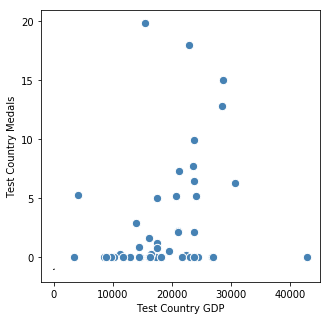

In [7]:
x = GDP['AvgGDP']
x = x.values.reshape(-1,1)
y = GDP['AvgMedalsPerYear']
y = y.values.reshape(-1,1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=220)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

plt.figure(figsize=(5,5))
plt.scatter(x, y, c='steelblue', edgecolor='white', s=70)
x = np.array([min(temps['Temp']),max(temps['Temp'])])
f = lambda x: model.coef_[0]*x + model.intercept_
plt.plot(x,f(x),color='black', lw=1)
plt.ylabel("Test Country Medals")
plt.xlabel("Test Country GDP")
plt.show()

In [8]:
model.predict(x_train)

array([[ 2.5712018 ],
       [ 1.29329012],
       [ 0.96088671],
       [ 1.98105316],
       [ 3.85568212],
       [ 2.32378254],
       [ 1.39716606],
       [ 4.86298542],
       [ 2.99997061],
       [ 2.2830599 ],
       [ 3.31132224],
       [-0.31687245],
       [ 0.98487964],
       [ 3.85940853],
       [ 4.83184264],
       [ 2.2988745 ],
       [ 3.85906639],
       [ 1.04870484],
       [ 0.80341673],
       [ 7.81892664],
       [ 1.06113722],
       [ 0.71745975],
       [ 1.9361115 ],
       [ 3.33378586],
       [ 2.69642632],
       [-0.19669344],
       [ 4.49805624],
       [ 3.69508343],
       [ 3.29690917],
       [ 2.55362498],
       [ 4.5404463 ],
       [ 3.87001068],
       [ 3.44752814],
       [ 3.22146571]])

In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)
plt.figure(figsize=(5,5))
plt.scatter(x, y, c='steelblue', edgecolor='white', s=70)
plt.plot(x, model.predict(x), color='black', lw=2)
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[-20.21  89.6 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
###################################################################################3#####

In [ ]:
temps = temps.drop(temps[temps.AvgMedalsPerYear < 1].index)
GDP = GDP.drop(GDP[GDP.AvgMedalsPerYear < 1].index)

In [ ]:
# avg medals per year vs. temperature

plt.figure(figsize=(10,6))
plt.style.use('seaborn')
#plt.title("City Latitude vs. Temperature\nUpdated: "+ (time.strftime("%m/%d/%Y")))
#plt.xlabel("Latitude")
#plt.ylabel("Max Temperature (F)")
plt.scatter(temps["Temp"], temps["AvgMedalsPerYear"], alpha=.55,
            c="c", edgecolors="black", linewidth=1)
#plt.savefig('temperature.png')
plt.show()

In [ ]:
# avg medals per year vs. avg GDP

plt.figure(figsize=(10,6))
plt.style.use('seaborn')
#plt.title("City Latitude vs. Temperature\nUpdated: "+ (time.strftime("%m/%d/%Y")))
#plt.xlabel("Latitude")
#plt.ylabel("Max Temperature (F)")
plt.scatter(GDP["AvgGDP"], GDP["AvgMedalsPerYear"], alpha=.55,
            c="c", edgecolors="black", linewidth=1)
#plt.savefig('temperature.png')
plt.show()

In [ ]:
# avg medals per year vs. temperature

plt.figure(figsize=(10,6))
plt.style.use('seaborn')
#plt.title("City Latitude vs. Temperature\nUpdated: "+ (time.strftime("%m/%d/%Y")))
#plt.xlabel("Latitude")
#plt.ylabel("Max Temperature (F)")
plt.scatter(temps["Lat"], temps["AvgMedalsPerYear"], alpha=.55,
            c="c", edgecolors="black", linewidth=1)
#plt.savefig('temperature.png')
plt.show()